In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
dataset = datasets.MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
train_dataset, val_dataset = train_test_split(dataset, test_size=0.1)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

Visualization

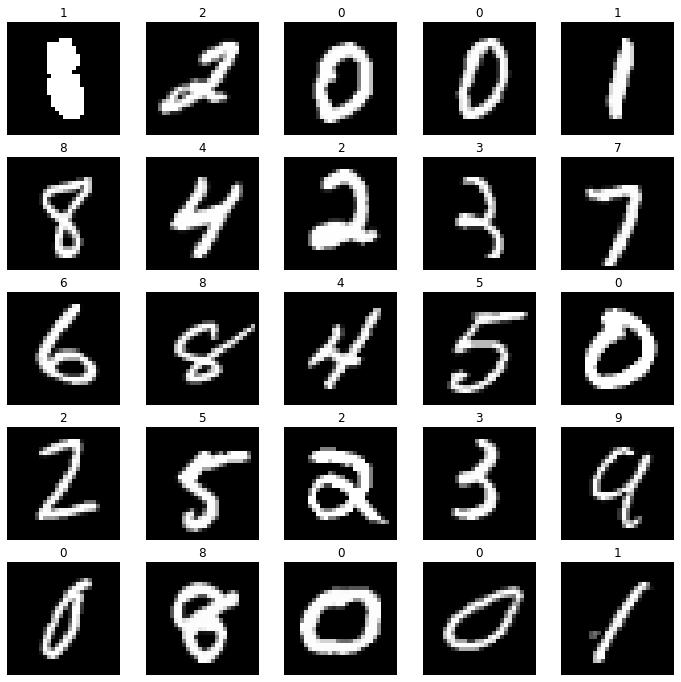

In [5]:
k = 0
f, ax = plt.subplots(5, 5, figsize=(12, 12))
example = iter(train_loader)
samples, targets = example.next()

for i in range(5):
  for j in range(5):    
    ax[i, j].imshow(samples[k].numpy().squeeze(0), cmap='gray')
    ax[i, j].set_title(targets[k].item())
    ax[i, j].axis('off')

    k += 1
plt.show()

Fully-connected NN classification

In [6]:
class MNISTnet(nn.Module):
  def __init__(self, n_hidden_neurons):
    super(MNISTnet, self).__init__()
    self.fc1 = nn.Linear(784, n_hidden_neurons)
    self.act = nn.Sigmoid()
    self.fc2 = nn.Linear(n_hidden_neurons, 10)

  def forward(self, x):
    x = self.fc1(x.view(-1, 784))
    x = self.act(x)
    x = self.fc2(x)

    return x

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
mnist_net = MNISTnet(50).to(device)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1e-3)

In [41]:
def train(model, num_epochs, train_loader, test_loader, optimizer, scheduler=None):
  epoch_train_loss = []
  epoch_val_loss = []
  accuracy_epoch = []

  batch_train_loss = []
  batch_val_loss = []
  accuracy_batch = []

  for epoch in range(num_epochs):

    model.train()
    for features, targets in train_loader:
      features = features.to(device)
      targets = targets.to(device)
      
      optimizer.zero_grad()
      outputs = model(features)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()

      batch_train_loss.append(loss.item())
      
    model.eval()
    with torch.no_grad():
      for features, targets in val_loader:      
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        loss = loss_fn(outputs, targets)
        accuracy_value = (outputs.argmax(dim=1) == targets).float().mean()

        batch_val_loss.append(loss.item())
        accuracy_batch.append(accuracy_value.item())
    
    epoch_train_loss.append(np.mean(batch_train_loss))
    epoch_val_loss.append(np.mean(batch_val_loss))
    accuracy_epoch.append(np.mean(accuracy_batch))

    batch_train_loss.clear()
    batch_val_loss.clear()
    accuracy_batch.clear()

    if scheduler is not None:
      scheduler.step()

    print(f'Epoch: {epoch+1}, Train: {epoch_train_loss[-1]}, Test: {epoch_val_loss[-1]}, Accuracy: {accuracy_epoch[-1]}')
    print('_'*10, end='\n\n')

  return model, epoch_train_loss, epoch_val_loss, accuracy_epoch  

In [10]:
mnist_net, train_data_loss, val_data_loss, accuracy = train(mnist_net, 20, train_loader, val_loader, optimizer)

Epoch: 1, Train: 0.8646819956876614, Test: 0.3901957790056864, Accuracy: 0.9074999799331029
__________

Epoch: 2, Train: 0.33289742505660763, Test: 0.2789628488322099, Accuracy: 0.9271666487058003
__________

Epoch: 3, Train: 0.2612512792012206, Test: 0.23902370519936084, Accuracy: 0.9341666479905446
__________

Epoch: 4, Train: 0.22375282457581272, Test: 0.2136583852271239, Accuracy: 0.9398333132266998
__________

Epoch: 5, Train: 0.1984964940627968, Test: 0.19628151394426824, Accuracy: 0.9438333143790563
__________

Epoch: 6, Train: 0.1798817851477199, Test: 0.18265181618432205, Accuracy: 0.9476666470368703
__________

Epoch: 7, Train: 0.1646205761504394, Test: 0.1732707366347313, Accuracy: 0.9496666471163432
__________

Epoch: 8, Train: 0.15177760536058083, Test: 0.16788732558488845, Accuracy: 0.9496666471163432
__________

Epoch: 9, Train: 0.14099569758745256, Test: 0.15765654320518177, Accuracy: 0.9518333117167155
__________

Epoch: 10, Train: 0.13145704547426215, Test: 0.15270256

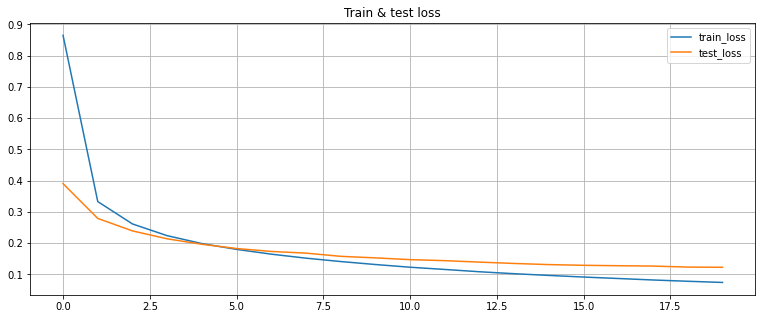

In [11]:
plt.figure(figsize=(13, 5))
plt.plot(train_data_loss, label='train_loss')
plt.plot(val_data_loss, label='test_loss')
plt.title('Train & test loss')
plt.legend()
plt.grid()
plt.show()

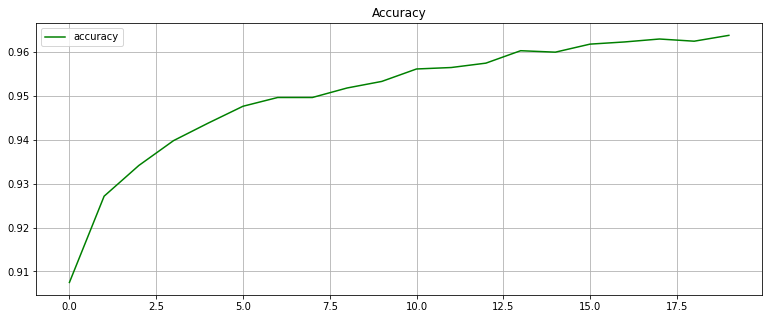

In [12]:
plt.figure(figsize=(13, 5))
plt.plot(accuracy, 'g', label='accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [13]:
features, targets = iter(test_loader).next()
features = features.to(device)
targets = targets.to(device)
outputs = mnist_net(features)
accuracy = (outputs.argmax(dim=1) == targets).float().mean()
print('Test accuracy:', round(accuracy.item(), 4))

Test accuracy: 0.9643


Convolutional NN classification (LeNet)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

In [15]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
    self.act = nn.Tanh()
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=120, out_features=84)
    self.fc2 = nn.Linear(in_features=84, out_features=10)


  def forward(self, x):
    x = self.pool(self.act(self.conv1(x)))
    x = self.pool(self.act(self.conv2(x)))
    x = self.act(self.conv3(x))
    x = self.flatten(x)
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    return x

In [16]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
le_net = LeNet5().to(device)

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(le_net.parameters(), lr=1e-3)

In [18]:
le_net, train_data_loss, val_data_loss, accuracy = train(le_net, 10, train_loader, val_loader, optimizer)

Epoch: 1, Train: 1.0700851728518803, Test: 0.897698387503624, Accuracy: 0.9446666489044825
__________

Epoch: 2, Train: 0.8742930158420845, Test: 0.8600955406824747, Accuracy: 0.9639999757210413
__________

Epoch: 3, Train: 0.8470744019305264, Test: 0.8516465286413829, Accuracy: 0.9681666404008865
__________

Epoch: 4, Train: 0.8355480345310988, Test: 0.8394337147474289, Accuracy: 0.9759999692440033
__________

Epoch: 5, Train: 0.8278886397679647, Test: 0.8356522311766942, Accuracy: 0.9781666318575541
__________

Epoch: 6, Train: 0.8232833425203959, Test: 0.8286487778027852, Accuracy: 0.9814999709526698
__________

Epoch: 7, Train: 0.8198253613931161, Test: 0.8281217734018962, Accuracy: 0.981499969959259
__________

Epoch: 8, Train: 0.8162621313775027, Test: 0.8236464371283849, Accuracy: 0.984499971071879
__________

Epoch: 9, Train: 0.8145244635917522, Test: 0.8218763361374537, Accuracy: 0.9854999701182048
__________

Epoch: 10, Train: 0.8119693222973082, Test: 0.8214821825424831, Acc

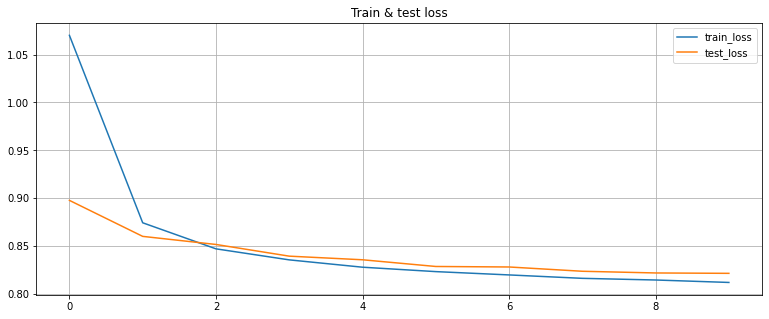

In [19]:
plt.figure(figsize=(13, 5))
plt.plot(train_data_loss, label='train_loss')
plt.plot(val_data_loss, label='test_loss')
plt.title('Train & test loss')
plt.legend()
plt.grid()
plt.show()

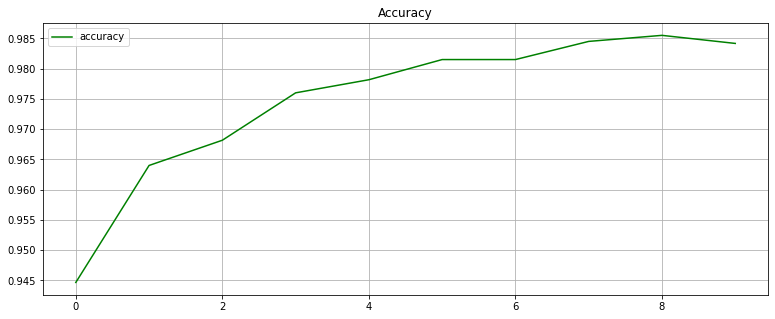

In [20]:
plt.figure(figsize=(13, 5))
plt.plot(accuracy, 'g', label='accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [21]:
features, targets = iter(test_loader).next()
features = features.to(device)
targets = targets.to(device)
outputs = le_net(features)
accuracy = (outputs.argmax(dim=1) == targets).float().mean()
print('Test accuracy:', round(accuracy.item(), 4))

Test accuracy: 0.9856


Improved LeNet classification

In [42]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

In [43]:
class LeNetULT(nn.Module):
  def __init__(self):
    super(LeNetULT, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.batchnorm1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.batchnorm3 = nn.BatchNorm2d(64)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=3136, out_features=784)
    self.batchnorm4 = nn.BatchNorm1d(784)
    self.fc2 = nn.Linear(in_features=784, out_features=10)
    self.act = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = self.pool(self.conv1(x))
    x = self.act(self.batchnorm1(x))
    x = self.pool(self.conv2(x))
    x = self.act(self.batchnorm2(x))
    x = self.act(self.batchnorm3(self.conv3(x)))
    x = self.flatten(x)
    x = self.act(self.batchnorm4(self.fc1(x)))
    x = self.act(self.fc2(x))
    return x

In [44]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
le_net_ult = LeNetULT().to(device)

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(le_net_ult.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

In [47]:
le_net_ult, train_data_loss, val_data_loss, accuracy = train(le_net_ult, 20, train_loader, val_loader, optimizer, scheduler)

Epoch: 1, Train: 0.1626753940384973, Test: 0.060935409956922135, Accuracy: 0.9844999670982361
__________

Epoch: 2, Train: 0.040958587816674955, Test: 0.045193326318015654, Accuracy: 0.986333304643631
__________

Epoch: 3, Train: 0.021595912647468074, Test: 0.037468871505310135, Accuracy: 0.9879999707142512
__________

Epoch: 4, Train: 0.012992154288588575, Test: 0.03957710978187, Accuracy: 0.9881666362285614
__________

Epoch: 5, Train: 0.0075047839567694745, Test: 0.03375073396212732, Accuracy: 0.9888333042462667
__________

Epoch: 6, Train: 0.0043124758360338295, Test: 0.03761066279063622, Accuracy: 0.9881666392087937
__________

Epoch: 7, Train: 0.0032670353143691533, Test: 0.03668875048169866, Accuracy: 0.9896666407585144
__________

Epoch: 8, Train: 0.0032454645544122388, Test: 0.03905164065266339, Accuracy: 0.9881666352351507
__________

Epoch: 9, Train: 0.0025012920817567242, Test: 0.04343051354808267, Accuracy: 0.9884999722242356
__________

Epoch: 10, Train: 0.003827690330136

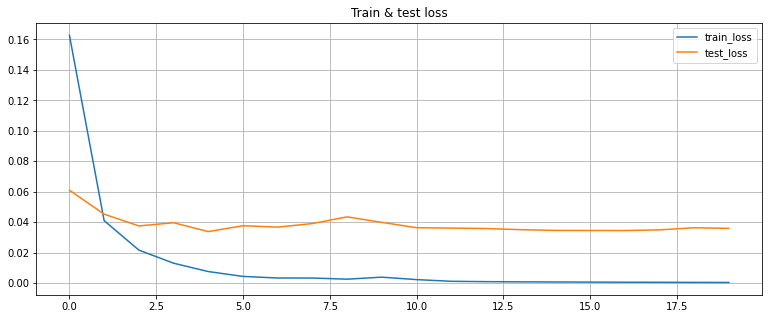

In [48]:
plt.figure(figsize=(13, 5))
plt.plot(train_data_loss, label='train_loss')
plt.plot(val_data_loss, label='test_loss')
plt.title('Train & test loss')
plt.legend()
plt.grid()
plt.show()

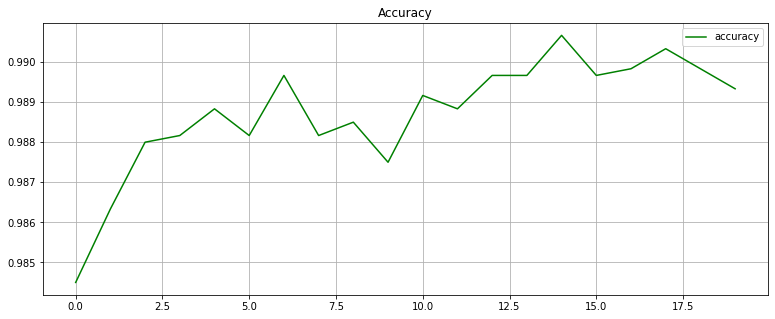

In [49]:
plt.figure(figsize=(13, 5))
plt.plot(accuracy, 'g', label='accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [50]:
features, targets = iter(test_loader).next()
features = features.to(device)
targets = targets.to(device)
outputs = le_net_ult(features)
accuracy = (outputs.argmax(dim=1) == targets).float().mean()
print('Test accuracy:', round(accuracy.item(), 4))

Test accuracy: 0.9918
